<a href="https://colab.research.google.com/github/itssneha668/AI-Lab/blob/main/ailab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comparative Analysis of Deep Learning Architectures on CIFAR-10 Using PyTorch

#### “Implementation, Training and Performance Evaluation of Neural Networks on CIFAR-10 using PyTorch”

#### Name: Sneha Pandey
#### Roll No: ACE080BEI033 (A2)


#### 1️. Introduction
####  Objective

 The main objective of this project is to:

- Implement three different deep learning models:

a. Fully Connected Neural Network (SimpleNN)

b. Modified AlexNet for CIFAR-10

c. TinyVGG

- Train all three models using the same optimizer and loss function to ensure fair comparison.

- Compare their performance based on:

  Test Accuracy

  Training Time

  Convergence Behavior

  Model Complexity (Total Trainable Parameters)

  Generalization Capability

### Import Libraries

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In this step, essential libraries required for model building, training, and visualization are imported.

torch → Core PyTorch framework

torch.nn → For defining neural network layers

torch.optim → For optimization algorithms

torchvision → Provides datasets and image transformations

matplotlib → Used for plotting graphs

This step initializes all necessary tools required to build and evaluate the models.

### Device Configuration

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Load Dataset

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

### Visualization:

In [14]:
import matplotlib.pyplot as plt
import torchvision

# Simple function to show CIFAR-10 images
def show_sample_images(images, labels, classes, n=8):
    """
    Display a grid of n images from a batch.
    """
    img_grid = torchvision.utils.make_grid(images[:n])
    img_grid = img_grid / 2 + 0.5  # undo normalization
    npimg = img_grid.numpy()

    plt.figure(figsize=(10,2))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.show()

    # Print labels
    print(' | '.join(f'{classes[labels[j]]}' for j in range(n)))


#### Example Usage (before training):

In [15]:
classes = ['snake', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck','airplane']


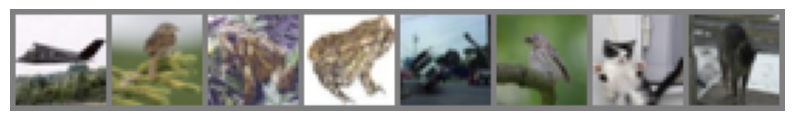

snake | cat | horse | horse | airplane | cat | deer | deer


In [16]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show 8 images
show_sample_images(images, labels, classes)


### Model 1 — SimpleNN (Baseline)

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN,self).__init__()
        self.fc1 = nn.Linear(3072,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Model 2 — AlexNet (Modified for CIFAR-10)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


### Model 3 — TinyVGG

In [19]:
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG,self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

### Train All Models

In [20]:
!pip install tqdm

In [21]:
from tqdm import tqdm

### Define Training Function

In [29]:

# Updated train_model with loss tracking
def train_model(model, trainloader, testloader, epochs=10, lr=0.001, use_tqdm=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch_list = []
    loss_list = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        iterator = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}") if use_tqdm else trainloader

        for images, labels in iterator:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        epoch_list.append(epoch + 1)
        loss_list.append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} Completed - Loss: {epoch_loss:.4f}")

    training_time = time.time() - start_time

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    parameters = sum(p.numel() for p in model.parameters())


    print(f"\nTraining Completed in {training_time:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Total Parameters: {parameters}")

    # Correctly return all
    return training_time, accuracy, parameters, epoch_list, loss_list

### Train Your Models

In [30]:
# SimpleNN
model1 = SimpleNN()
time1, acc1, params1, e1, l1 = train_model(model1, trainloader, testloader, epochs=10)

# AlexNet
model2 = AlexNetCIFAR()
time2, acc2, params2, e2, l2 = train_model(model2, trainloader, testloader, epochs=10)

# TinyVGG
model3 = TinyVGG()
time3, acc3, params3, e3, l3 = train_model(model3, trainloader, testloader, epochs=10)


Epoch 1/10: 100%|██████████| 391/391 [00:13<00:00, 28.71it/s]


Epoch 1/10 Completed - Loss: 1.6291


Epoch 2/10: 100%|██████████| 391/391 [00:13<00:00, 28.79it/s]


Epoch 2/10 Completed - Loss: 1.4101


Epoch 3/10: 100%|██████████| 391/391 [00:13<00:00, 28.24it/s]


Epoch 3/10 Completed - Loss: 1.2955


Epoch 4/10: 100%|██████████| 391/391 [00:13<00:00, 28.89it/s]


Epoch 4/10 Completed - Loss: 1.1980


Epoch 5/10: 100%|██████████| 391/391 [00:14<00:00, 27.35it/s]


Epoch 5/10 Completed - Loss: 1.1137


Epoch 6/10: 100%|██████████| 391/391 [00:13<00:00, 28.26it/s]


Epoch 6/10 Completed - Loss: 1.0320


Epoch 7/10: 100%|██████████| 391/391 [00:13<00:00, 29.01it/s]


Epoch 7/10 Completed - Loss: 0.9534


Epoch 8/10: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s]


Epoch 8/10 Completed - Loss: 0.8849


Epoch 9/10: 100%|██████████| 391/391 [00:13<00:00, 29.76it/s]


Epoch 9/10 Completed - Loss: 0.8071


Epoch 10/10: 100%|██████████| 391/391 [00:15<00:00, 25.92it/s]


Epoch 10/10 Completed - Loss: 0.7351

Training Completed in 139.10 seconds
Test Accuracy: 54.19%
Total Parameters: 1707274


Epoch 1/10: 100%|██████████| 391/391 [00:25<00:00, 15.41it/s]


Epoch 1/10 Completed - Loss: 1.5583


Epoch 2/10: 100%|██████████| 391/391 [00:24<00:00, 15.77it/s]


Epoch 2/10 Completed - Loss: 1.1207


Epoch 3/10: 100%|██████████| 391/391 [00:26<00:00, 15.03it/s]


Epoch 3/10 Completed - Loss: 0.9041


Epoch 4/10: 100%|██████████| 391/391 [00:27<00:00, 14.15it/s]


Epoch 4/10 Completed - Loss: 0.7768


Epoch 5/10: 100%|██████████| 391/391 [00:27<00:00, 14.26it/s]


Epoch 5/10 Completed - Loss: 0.6719


Epoch 6/10: 100%|██████████| 391/391 [00:25<00:00, 15.36it/s]


Epoch 6/10 Completed - Loss: 0.5963


Epoch 7/10: 100%|██████████| 391/391 [00:27<00:00, 14.23it/s]


Epoch 7/10 Completed - Loss: 0.5320


Epoch 8/10: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s]


Epoch 8/10 Completed - Loss: 0.4753


Epoch 9/10: 100%|██████████| 391/391 [00:26<00:00, 14.73it/s]


Epoch 9/10 Completed - Loss: 0.4347


Epoch 10/10: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Epoch 10/10 Completed - Loss: 0.3857

Training Completed in 263.24 seconds
Test Accuracy: 78.33%
Total Parameters: 35855178


Epoch 1/10: 100%|██████████| 391/391 [00:19<00:00, 20.58it/s]


Epoch 1/10 Completed - Loss: 1.5150


Epoch 2/10: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]


Epoch 2/10 Completed - Loss: 1.0568


Epoch 3/10: 100%|██████████| 391/391 [00:19<00:00, 19.86it/s]


Epoch 3/10 Completed - Loss: 0.8522


Epoch 4/10: 100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch 4/10 Completed - Loss: 0.7233


Epoch 5/10: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s]


Epoch 5/10 Completed - Loss: 0.6220


Epoch 6/10: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]


Epoch 6/10 Completed - Loss: 0.5302


Epoch 7/10: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]


Epoch 7/10 Completed - Loss: 0.4460


Epoch 8/10: 100%|██████████| 391/391 [00:20<00:00, 18.98it/s]


Epoch 8/10 Completed - Loss: 0.3682


Epoch 9/10: 100%|██████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch 9/10 Completed - Loss: 0.2964


Epoch 10/10: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]


Epoch 10/10 Completed - Loss: 0.2370

Training Completed in 196.69 seconds
Test Accuracy: 72.89%
Total Parameters: 591274


### Compare Results

In [31]:
results = {
    "SimpleNN": (acc1, time1, params1),
    "AlexNet": (acc2, time2, params2),
    "TinyVGG": (acc3, time3, params3)
}

for model_name, values in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {values[0]:.2f}%")
    print(f"Training Time: {values[1]:.2f} seconds")
    print(f"Parameters: {values[2]}")



Model: SimpleNN
Accuracy: 54.19%
Training Time: 139.10 seconds
Parameters: 1707274

Model: AlexNet
Accuracy: 78.33%
Training Time: 263.24 seconds
Parameters: 35855178

Model: TinyVGG
Accuracy: 72.89%
Training Time: 196.69 seconds
Parameters: 591274


### Features of This Training Loop
- Real-time batch progress using tqdm

- Loss displayed after every epoch

- Automatic evaluation after training

- Training time measurement

- Counting total trainable parameters

 This ensures consistency across models for fair comparison.

In [32]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:   # using global testloader
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [33]:
def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [34]:
acc_simplenn = evaluate_model(model1, testloader)
acc_alexnet = evaluate_model(model2, testloader)
acc_tinyvgg = evaluate_model(model3, testloader)

In [35]:
print(f"SimpleCNN Accuracy: {acc_simplenn:.2f}%")
print(f"AlexNet Accuracy: {acc_alexnet:.2f}%")
print(f"TinyVGG Accuracy: {acc_tinyvgg:.2f}%")


SimpleCNN Accuracy: 54.19%
AlexNet Accuracy: 78.33%
TinyVGG Accuracy: 72.89%


### Compare Results in a Table

In [36]:
results = {
    "SimpleNN": (acc1, time1, params1),
    "AlexNet": (acc2, time2, params2),
    "TinyVGG": (acc3, time3, params3)
}

print("\nModel Comparison:")
print("Model\t\tAccuracy\tTraining Time\tParameters")
for model, vals in results.items():
    print(f"{model}\t{vals[0]:.2f}%\t\t{vals[1]:.2f}s\t\t{vals[2]}")


Model Comparison:
Model		Accuracy	Training Time	Parameters
SimpleNN	54.19%		139.10s		1707274
AlexNet	78.33%		263.24s		35855178
TinyVGG	72.89%		196.69s		591274


### Plot Loss/Accuracy Curves

Epoch 1/10: 100%|██████████| 391/391 [00:15<00:00, 25.95it/s]


Epoch 1/10 Completed - Loss: 1.6323


Epoch 2/10: 100%|██████████| 391/391 [00:14<00:00, 27.67it/s]


Epoch 2/10 Completed - Loss: 1.4160


Epoch 3/10: 100%|██████████| 391/391 [00:13<00:00, 29.93it/s]


Epoch 3/10 Completed - Loss: 1.2955


Epoch 4/10: 100%|██████████| 391/391 [00:13<00:00, 28.39it/s]


Epoch 4/10 Completed - Loss: 1.2026


Epoch 5/10: 100%|██████████| 391/391 [00:13<00:00, 28.33it/s]


Epoch 5/10 Completed - Loss: 1.1137


Epoch 6/10: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Epoch 6/10 Completed - Loss: 1.0331


Epoch 7/10: 100%|██████████| 391/391 [00:15<00:00, 24.77it/s]


Epoch 7/10 Completed - Loss: 0.9500


Epoch 8/10: 100%|██████████| 391/391 [00:14<00:00, 27.19it/s]


Epoch 8/10 Completed - Loss: 0.8730


Epoch 9/10: 100%|██████████| 391/391 [00:13<00:00, 29.91it/s]


Epoch 9/10 Completed - Loss: 0.7969


Epoch 10/10: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s]


Epoch 10/10 Completed - Loss: 0.7227

Training Completed in 140.49 seconds
Test Accuracy: 54.39%
Total Parameters: 1707274


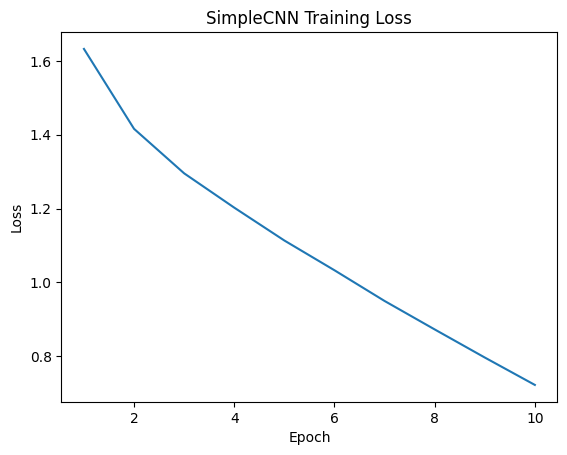

In [37]:
# Train model
model1 = SimpleNN()
time1, acc1, params1, e1, l1 = train_model(model1, trainloader, testloader, epochs=10)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(e1, l1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN Training Loss")
plt.show()


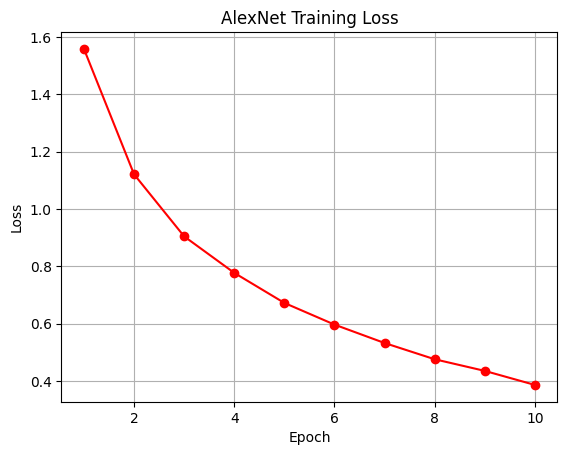

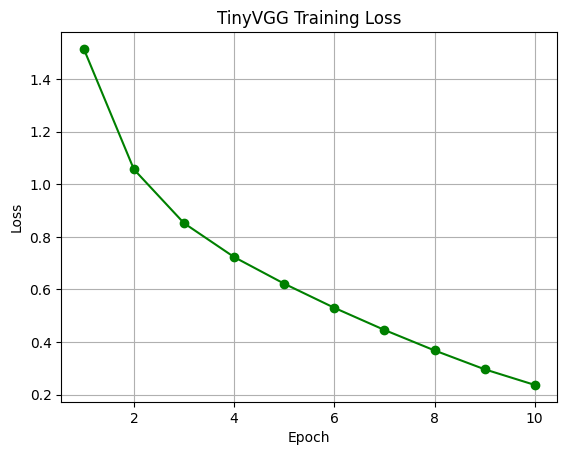

In [38]:

# AlexNet
plt.figure()
plt.plot(e2, l2, 'r-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("AlexNet Training Loss")
plt.grid(True)
plt.show()

# TinyVGG
plt.figure()
plt.plot(e3, l3, 'g-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TinyVGG Training Loss")
plt.grid(True)
plt.show()

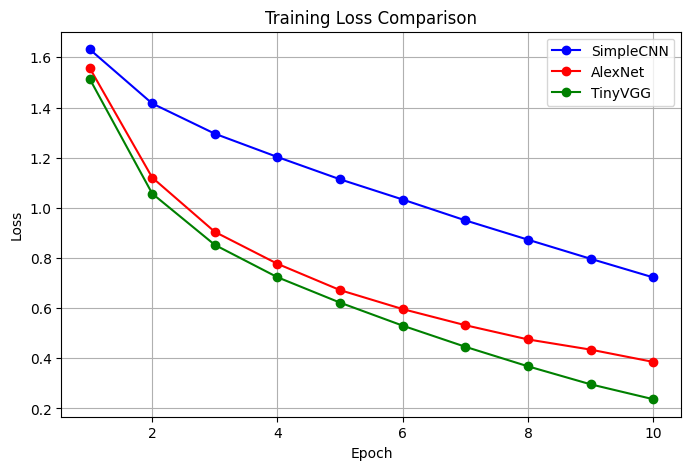

In [39]:

plt.figure(figsize=(8,5))
plt.plot(e1, l1, 'b-o', label="SimpleCNN")
plt.plot(e2, l2, 'r-o', label="AlexNet")
plt.plot(e3, l3, 'g-o', label="TinyVGG")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
plt.savefig("training_loss_comparison.png", dpi=300)

<Figure size 640x480 with 0 Axes>

### Summary Table (Accuracy, Time, Parameters)


In [41]:
import pandas as pd

summary = pd.DataFrame({
    "Model": ["SimpleCNN", "AlexNet", "TinyVGG"],
    "Accuracy (%)": [acc1, acc2, acc3],
    "Training Time (s)": [time1, time2, time3],
    "Parameters": [params1, params2, params3]
})

print(summary)

       Model  Accuracy (%)  Training Time (s)  Parameters
0  SimpleCNN         54.39         140.486020     1707274
1    AlexNet         78.33         263.240158    35855178
2    TinyVGG         72.89         196.687921      591274


#### Save Models

In [42]:
torch.save(model1.state_dict(), "SimpleNN.pth")
torch.save(model2.state_dict(), "AlexNet.pth")
torch.save(model3.state_dict(), "TinyVGG.pth")


### Discussion

In this project, three different neural network architectures were implemented and evaluated on the CIFAR-10 dataset.

#### - SimpleNN

A basic fully connected architecture.

Advantages:

- Simple implementation

- Faster training

- Moderate parameter count

Limitations:

- Cannot capture spatial features efficiently

- Lowest test accuracy

Since image data contains spatial hierarchies, fully connected networks struggle compared to convolutional models.

#### - AlexNet (Adapted Version)

A deep convolutional architecture with multiple feature extraction layers.

Advantages:

- Highest test accuracy

- Strong feature learning capability

- Better generalization

Limitations:

- Very high parameter count

- Longest training time

The improvement comes from:

- Convolution layers capturing local patterns

- Deeper structure enabling complex feature extraction

- ReLU activation improving convergence

#### - TinyVGG

A compact CNN architecture inspired by VGG.

Advantages:

- Fewer parameters

- Faster than AlexNet

- Good accuracy

Limitations:

- Slightly lower accuracy than AlexNet

- TinyVGG demonstrates that efficient architectures can achieve competitive performance with lower computational cost.

#### - Additional Observations
1️⃣ Accuracy vs Training Time Trade-off

Deeper and more complex models achieve higher accuracy but require longer training.

2️⃣ Model Complexity Impact

The number of parameters directly affects memory usage and computation time.

3️⃣ Generalization

Convolutional neural networks outperform fully connected networks in image classification due to spatial feature extraction.

### Conclusion

From the experimental results:

- AlexNet achieved the highest accuracy on CIFAR-10, demonstrating the power of deep convolutional networks.

- SimpleNN trained the fastest but produced the lowest accuracy, highlighting the limitations of fully connected layers for image data.

- TinyVGG offered a balanced trade-off between efficiency and performance.

### Key Takeaways

- Convolutional Neural Networks are more suitable for image classification tasks than fully connected networks.

- Increasing model depth improves performance but increases computational cost.

- Lightweight architectures like TinyVGG are practical for systems with limited resources.

- Understanding the balance between accuracy, training time, and model size is essential for real-world deep learning applications.